In [1]:
from astral import LocationInfo
from astral.sun import sun
import datetime as dt
from pathlib import Path  
import pytz
from pytz import timezone
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import seaborn as sns
import swifter
import sys

# Import Data

In [2]:
# state space model
ssm_archivals = pd.read_csv('./ws_hawaiionly_ssm_archivals_2022apr12.csv')

# cleaned data
master = pd.read_csv('./master.csv')

# metadata
meta = pd.read_csv('./ws_hawaiionly_ssm_archivals_dateranges_2022apr18.csv')

In [3]:
ssm_archivals

,eventid,tagnumber,ptt,taggingdate,length,sex,latitude,longitude,month,year,date
0,190000400,00P0291,29711,2000-10-16,457.0,M,21.772190,-158.562114,1,2001,01/03/2001 05:00
1,190000400,00P0291,29711,2000-10-16,457.0,M,21.288875,-158.486529,1,2001,01/04/2001 05:00
2,190000400,00P0291,29711,2000-10-16,457.0,M,20.934433,-158.189378,1,2001,01/05/2001 05:00
3,190000400,00P0291,29711,2000-10-16,457.0,M,20.675729,-157.986978,1,2001,01/06/2001 05:00
4,190000400,00P0291,29711,2000-10-16,457.0,M,20.431531,-157.861104,1,2001,01/07/2001 05:00
...,...,...,...,...,...,...,...,...,...,...,...
497,191901200,L330-2736,196867,2019-11-24,366.0,M,16.481396,-156.626439,4,2020,04/12/2020 05:00
498,191901200,L330-2736,196867,2019-11-24,366.0,M,16.467748,-156.196890,4,2020,04/13/2020 05:00
499,191901200,L330-2736,196867,2019-11-24,366.0,M,16.630509,-155.650666,4,2020,04/14/2020 05:00
500,191901200,L330-2736,196867,2019-11-24,366.0,M,16.964682,-155.076336,4,2020,04/15/2020 05:00


In [4]:
master #consider making all sharks have same resolution sampling because it is skewing the data - find min sampling rate and them resample - do in data_cleaning

,Unnamed: 0,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral)
0,0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk
1,1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk
2,2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk
3,3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk
4,4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk
...,...,...,...,...,...,...,...,...,...,...
1814402,1814402,191901200,2020-04-16 18:47:59-10:00,18,Dusk,303.3,11.500000,M,366.0,Dusk
1814403,1814403,191901200,2020-04-16 19:45:35-10:00,19,Night,146.3,19.880000,M,366.0,Dusk
1814404,1814404,191901200,2020-04-16 20:43:11-10:00,20,Night,163.3,19.120000,M,366.0,Night
1814405,1814405,191901200,2020-04-16 21:40:47-10:00,21,Night,147.3,20.640000,M,366.0,Night


In [5]:
meta

,eventid,tagnumber,ptt,taggingdate,length,sex,firstdate,lastdate
0,190000400,00P0291,29711,2000-10-16,457.00,M,01/03/2001 05:00,04/16/2001 05:00
1,190400900,04P0160,52933,2004-11-30,396.00,F,03/22/2005 05:00,06/10/2005 05:00
2,190502800,05P0132,62021,2005-12-15,480.00,F,03/31/2006 05:00,05/30/2006 05:00
3,190600200,05P0059,60983,2006-01-21,400.00,F,06/09/2006 05:00,09/03/2006 05:00
4,190601200,06A0555,68281,2006-10-10,426.72,M,02/09/2007 05:00,06/05/2007 05:00
5,190900200,08A0599,87568,2009-01-19,427.00,F,03/17/2009 05:00,06/09/2009 05:00
6,191901200,L330-2736,196867,2019-11-24,366.00,M,01/12/2020 05:00,04/16/2020 05:00


# Start pLaYinG!

Ideas: consider depth vs latitude or 3d dive profiles lat long depth - would need to merge dataframes in data cleaning doc - parallelize with mutiprocessing
maybe avge day and night time temp vs body size as a scatter plot for both males, females, all, and individuals

In [6]:
def plotHeatMap(df, Id):
    # Apply the default theme
    sns.set_theme()
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    
    binSize = 10
    maxDepth = 700
    bins = np.arange(0, maxDepth, binSize)
    df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])
    grouped = df.groupby(["Hour (UTC-10)", "Depth Bin"]).size().reset_index(name='count')
    grouped['percent'] = grouped['count'] / grouped.groupby("Hour (UTC-10)")['count'].transform('sum')
    piv = grouped.pivot("Depth Bin", "Hour (UTC-10)", "percent")
    ax = sns.heatmap(piv, robust=True, cbar_kws={'label': 'Fraction of Time Spent'})
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Hour')
    ax.set_title('Time Spent at Depth for ' + Id)

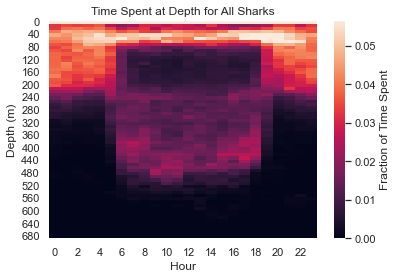

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


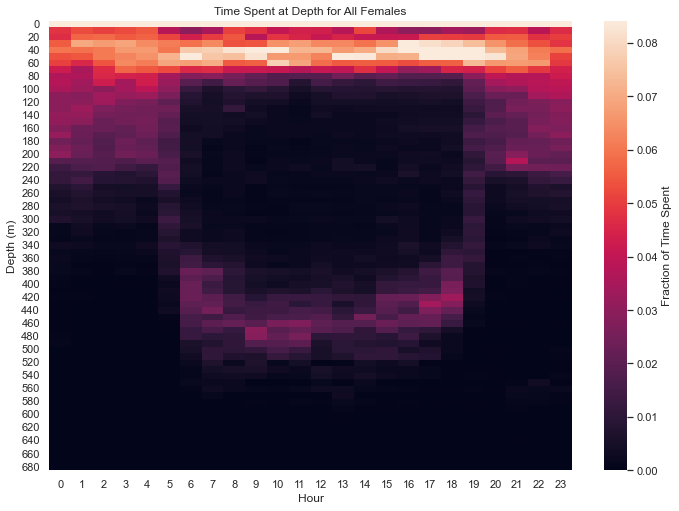

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


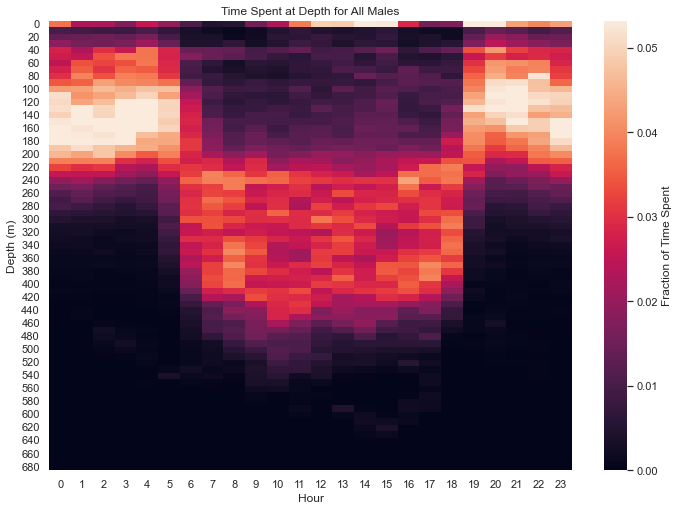

In [7]:
plotHeatMap(master, 'All Sharks')
plt.show()
plotHeatMap(master.loc[master['Sex'] == 'F'], 'All Females')
plt.show()
plotHeatMap(master.loc[master['Sex'] == 'M'], 'All Males')
plt.show()

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


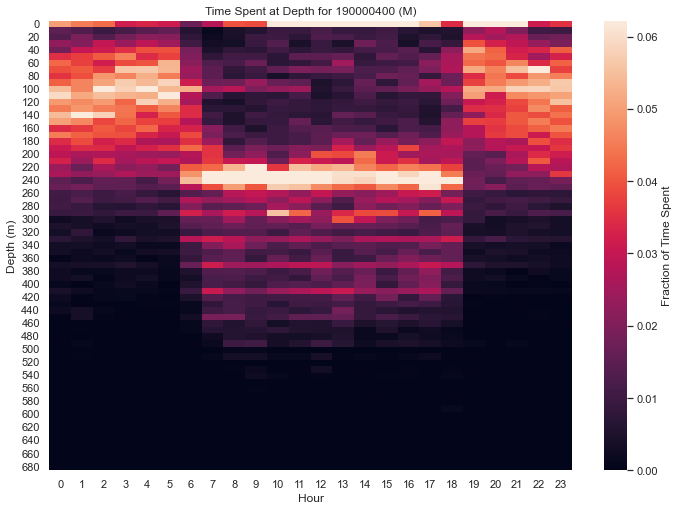

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


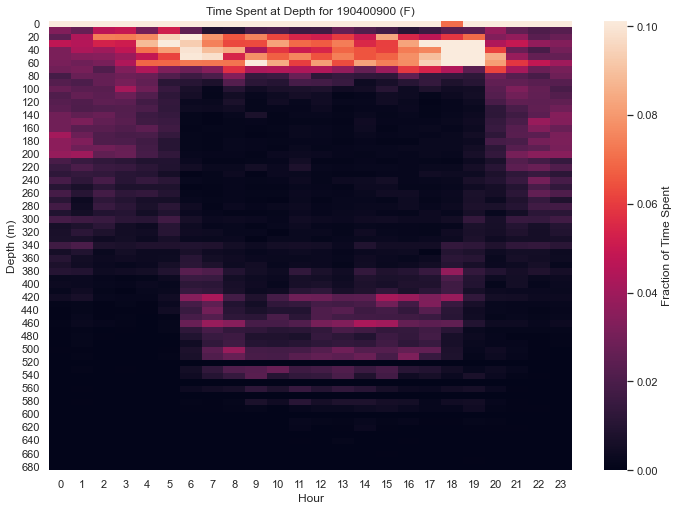

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


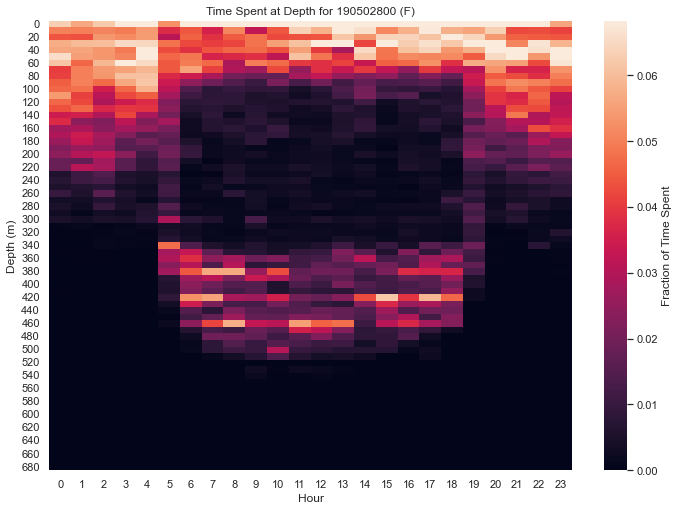

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


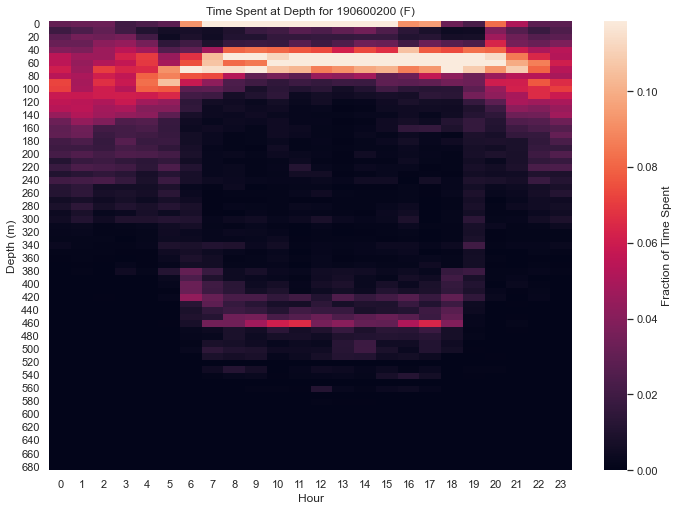

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


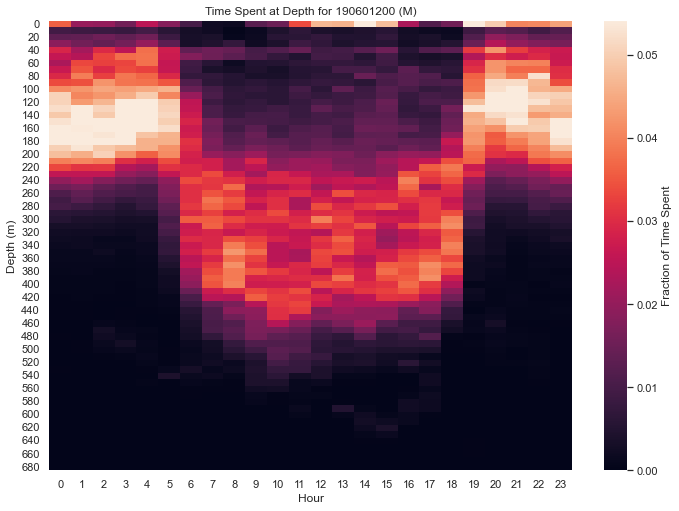

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


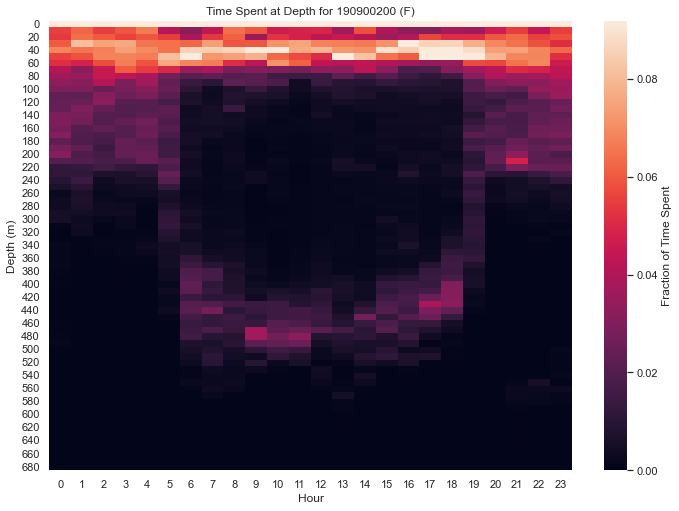

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_42579/731410221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


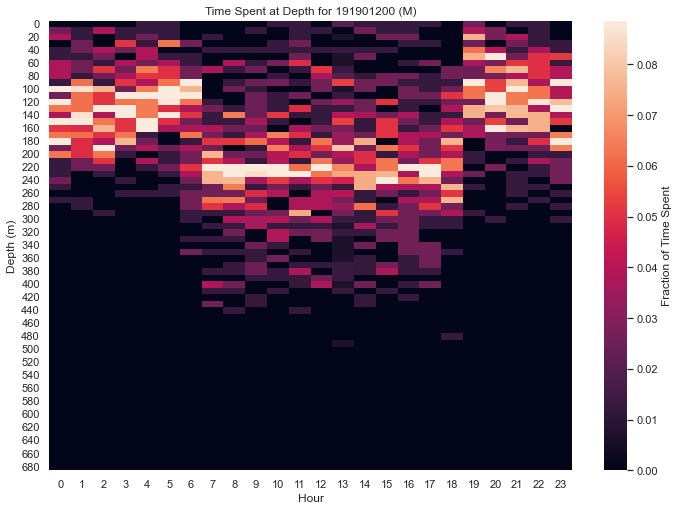

In [8]:
# heatmaps for individual shark dive profiles - small n - make sure one shark didn't throw off distributions - check for consistent bahavior
for i in range(len(meta["eventid"])):
    id = meta["eventid"][i]
    subset = master.loc[master['Id'] == id]
    plotHeatMap(subset, str(id) + ' (' + meta['sex'][i] +')')
    plt.show()

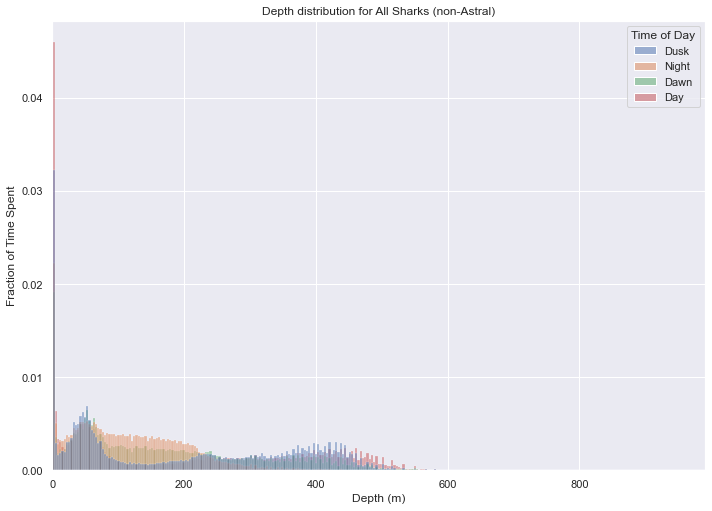

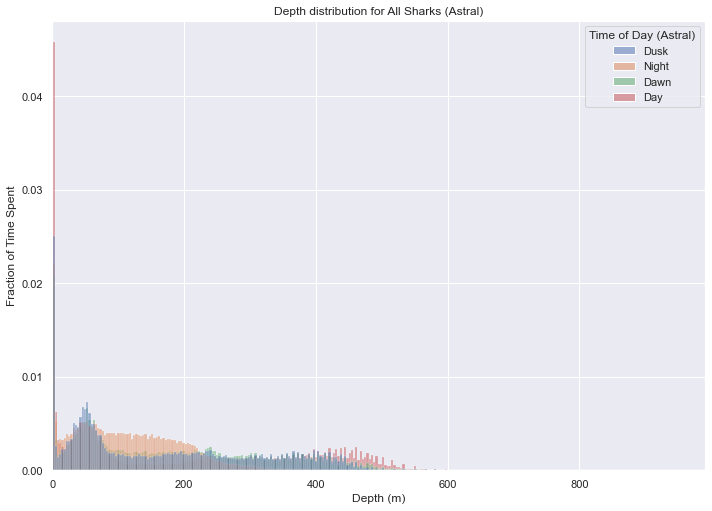

In [9]:
# compare Hueristic and Astral determined Time of Day
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.histplot(master, x="Depth(m)", hue="Time of Day", stat="density", common_norm=False)
ax.set_xlim(0, master["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for All Sharks (non-Astral)')
plt.show()

ax = sns.histplot(master, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, master["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for All Sharks (Astral)')
plt.show()

Text(0.5, 1.0, 'Depth distribution for All Sharks (Astral)')

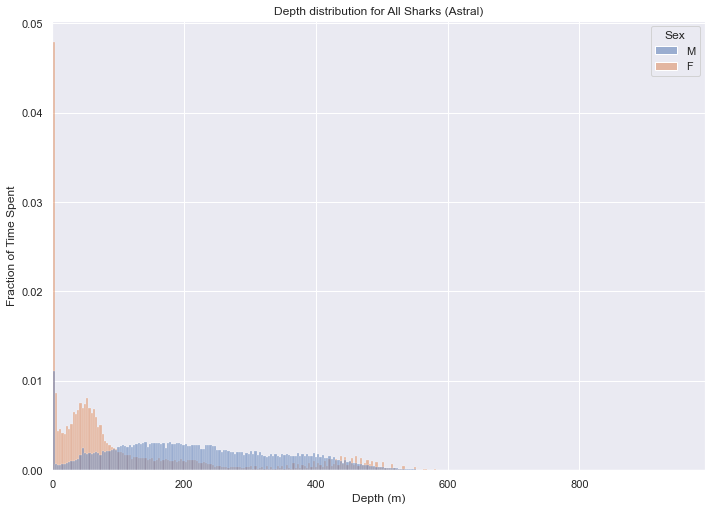

In [10]:
ax = sns.histplot(master, x="Depth(m)", hue="Sex", stat="density", common_norm=False)
ax.set_xlim(0, master["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for All Sharks (Astral)')

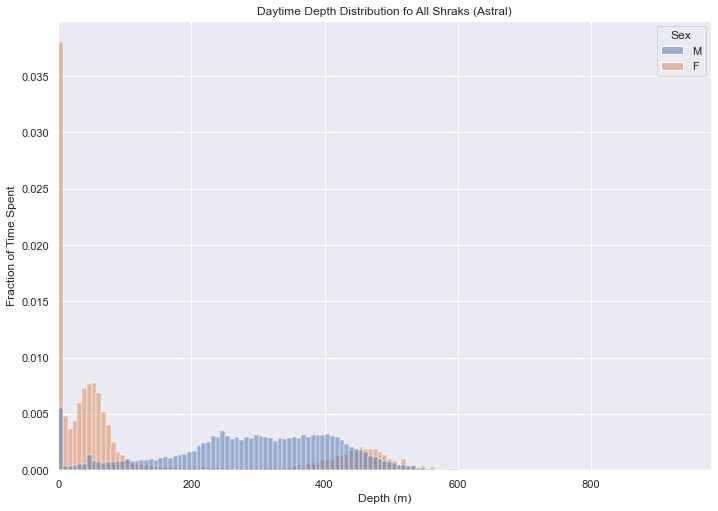

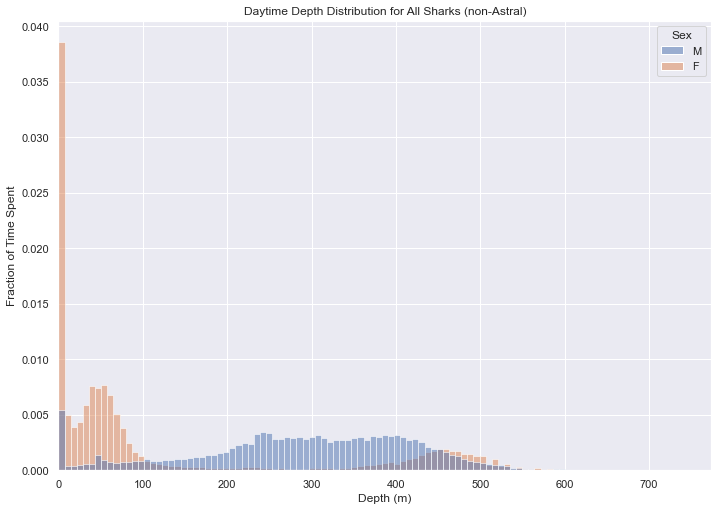

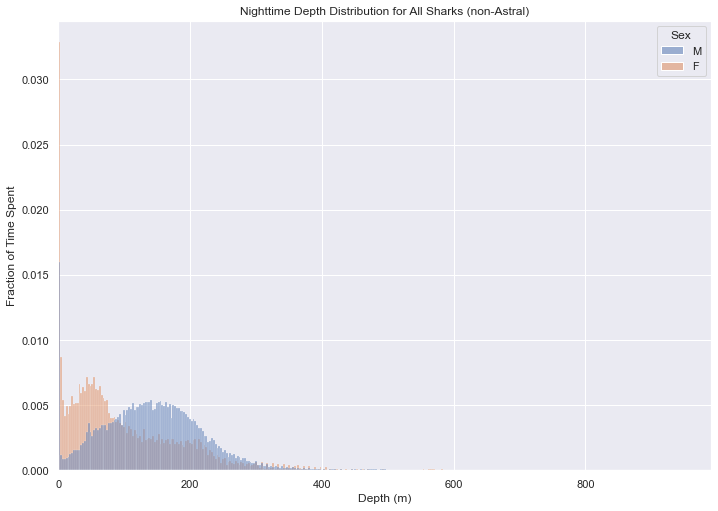

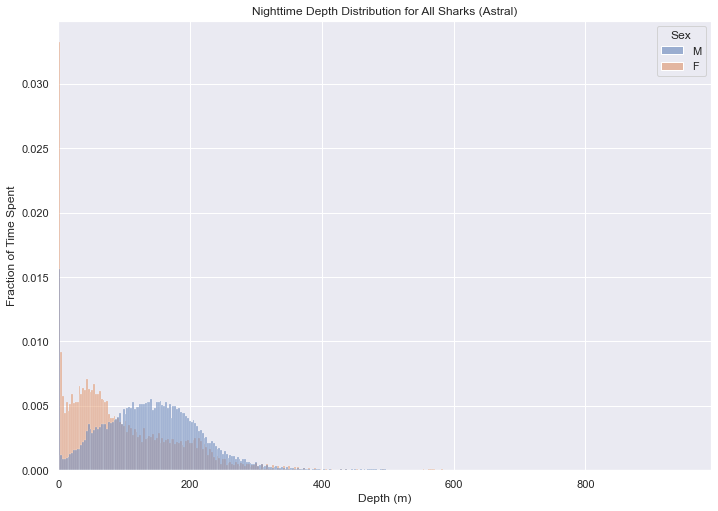

In [11]:
day = master.loc[master['Time of Day'] == 'Day']
night = master.loc[master['Time of Day'] == 'Night']

day_astral = master.loc[master['Time of Day (Astral)'] == 'Day']
night_astral = master.loc[master['Time of Day (Astral)'] == 'Night']

ax = sns.histplot(day_astral, x="Depth(m)", hue="Sex", stat="density", common_norm=False)
ax.set_xlim(0, day_astral["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Daytime Depth Distribution fo All Shraks (Astral)')
plt.show()

ax = sns.histplot(day, x="Depth(m)", hue="Sex", stat="density", common_norm=False)
ax.set_xlim(0, day["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Daytime Depth Distribution for All Sharks (non-Astral)')
plt.show()

ax = sns.histplot(night, x="Depth(m)", hue="Sex", stat="density", common_norm=False)
ax.set_xlim(0, night["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Nighttime Depth Distribution for All Sharks (non-Astral)')
plt.show()

ax = sns.histplot(night_astral, x="Depth(m)", hue="Sex", stat="density", common_norm=False)
ax.set_xlim(0, night_astral["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Nighttime Depth Distribution for All Sharks (Astral)')
plt.show()

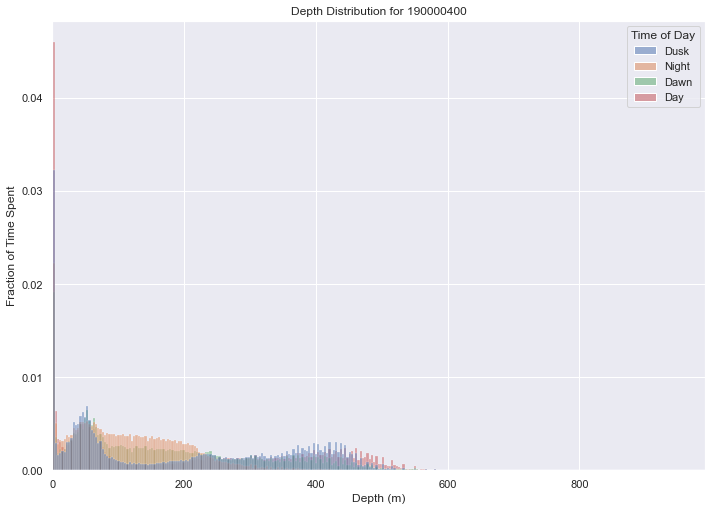

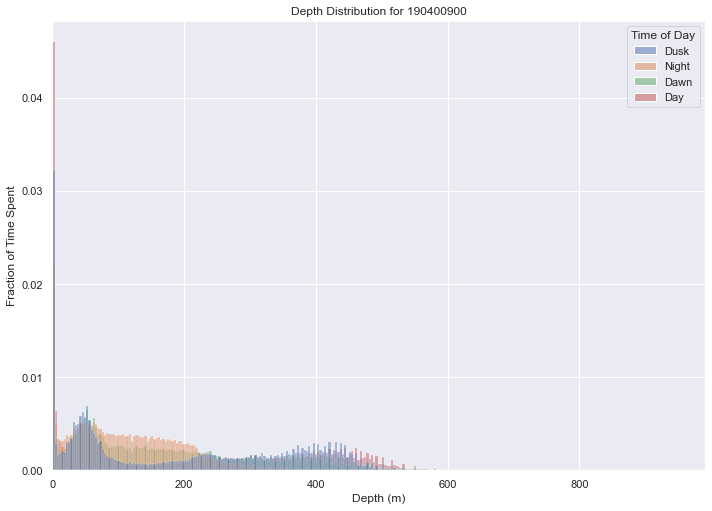

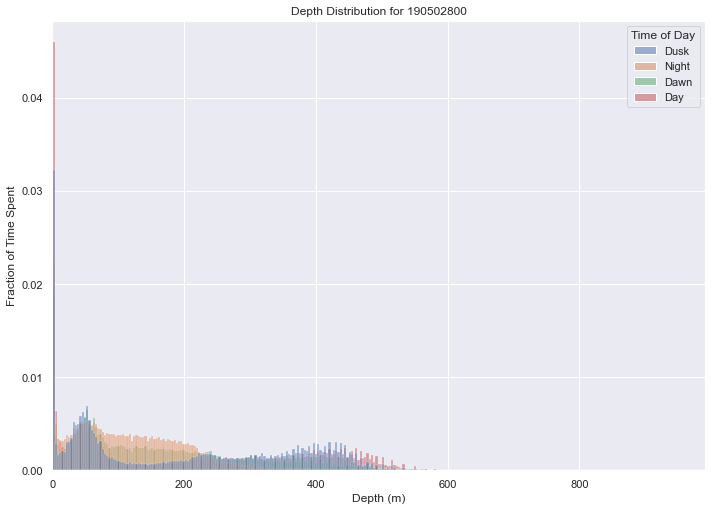

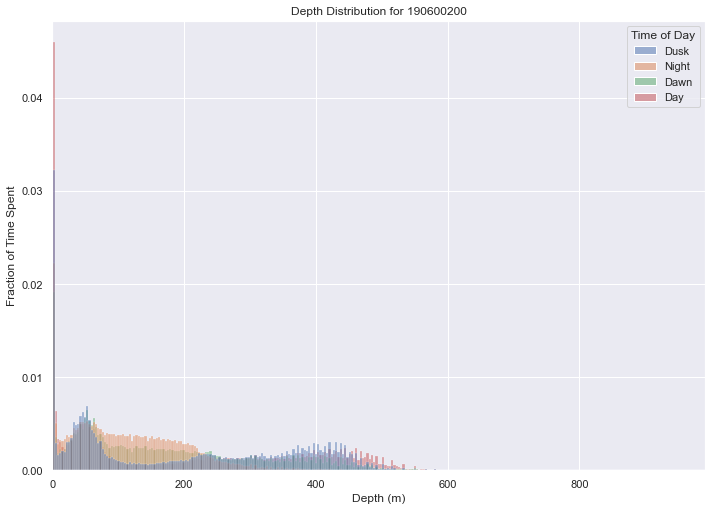

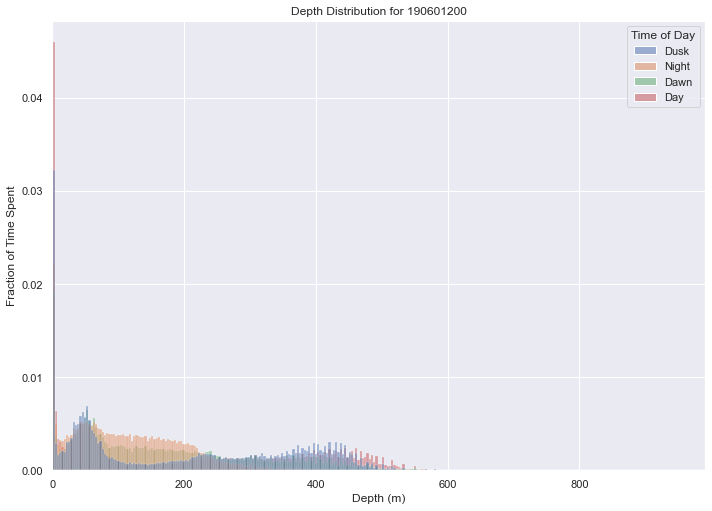

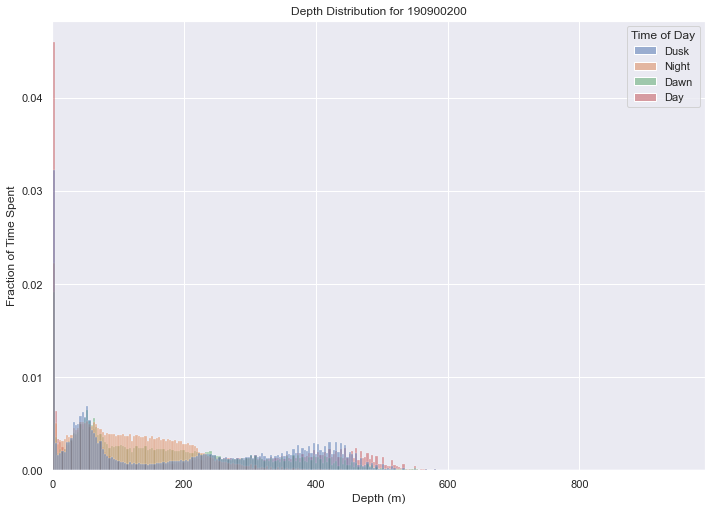

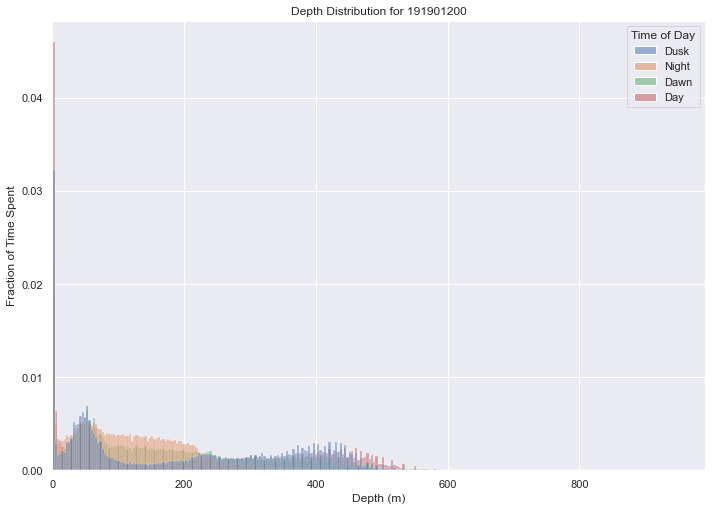

In [12]:
# individual shark dive profiles - small n - make sure one shark didn't throw off distributions - check for consistent bahavior
for id in meta["eventid"]:
    subset = master.loc[master['Id'] == id]
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.histplot(master, x="Depth(m)", hue="Time of Day", stat="density", common_norm=False)
    ax.set_xlim(0, master["Depth(m)"].max())
    ax.set_ylabel('Fraction of Time Spent')
    ax.set_xlabel('Depth (m)')
    ax.set_title('Depth Distribution for ' + str(id))
    plt.show()

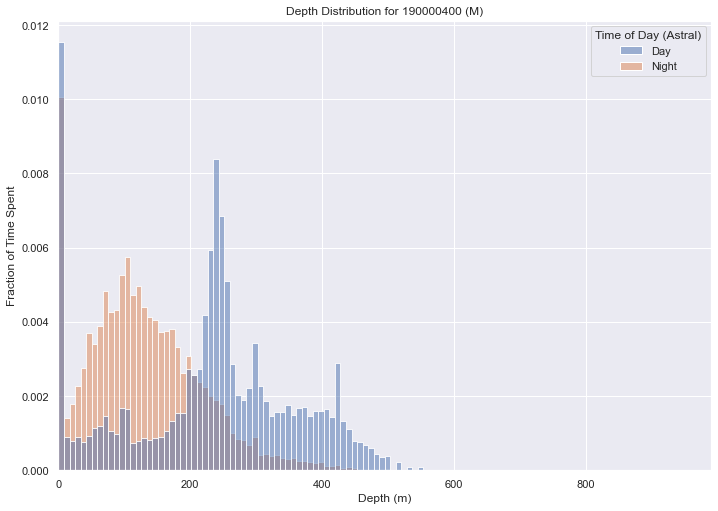

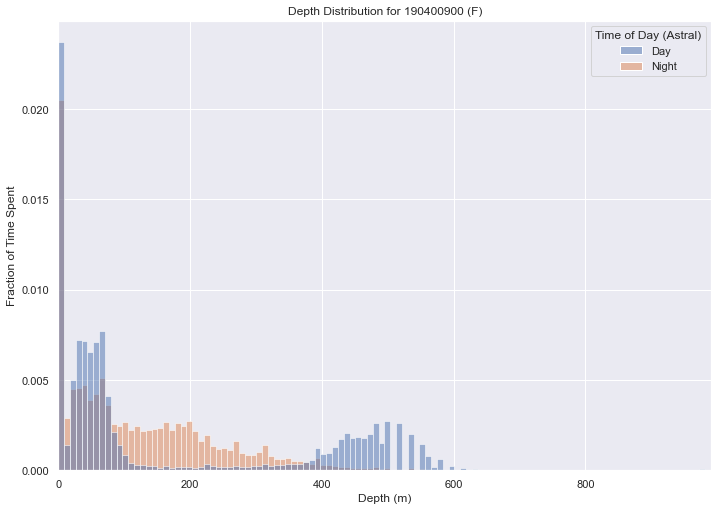

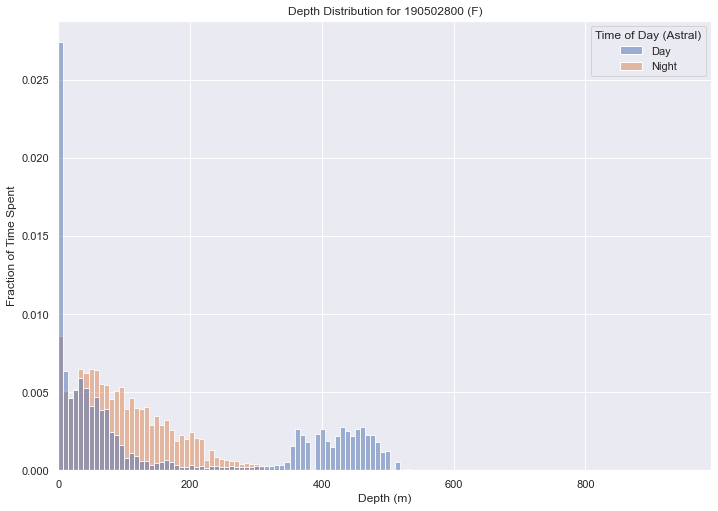

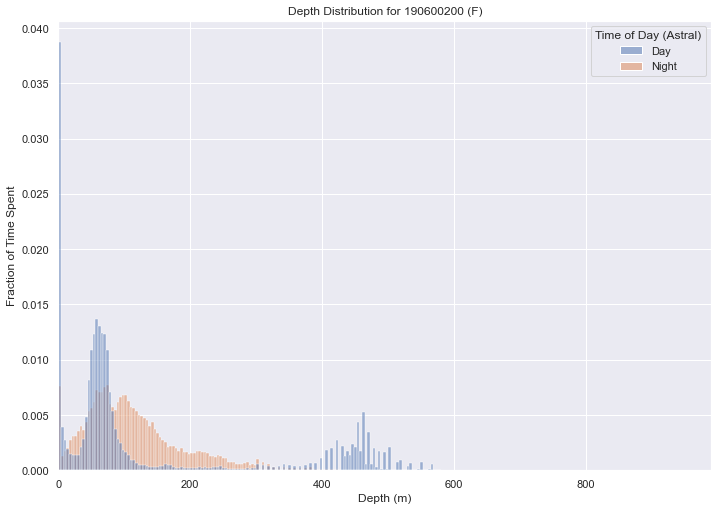

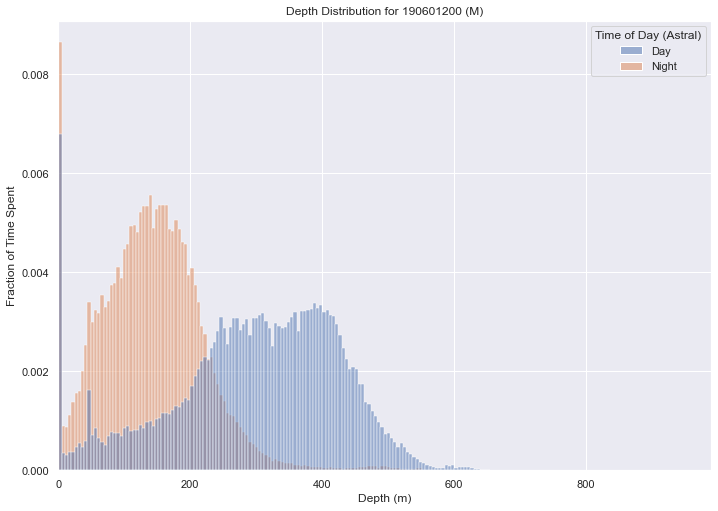

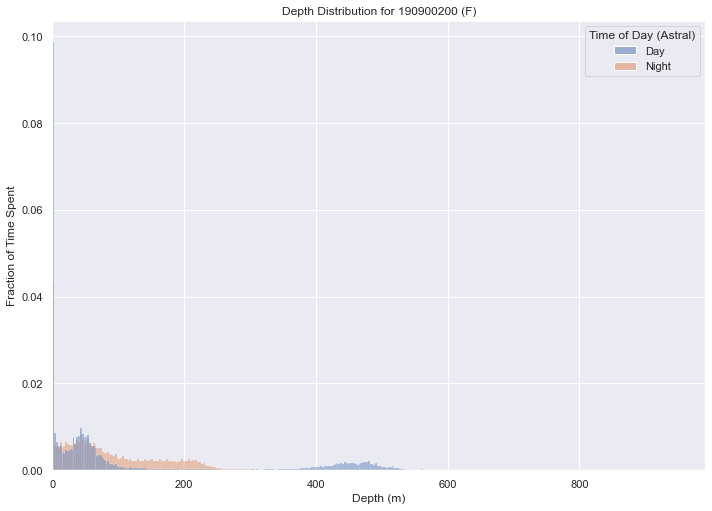

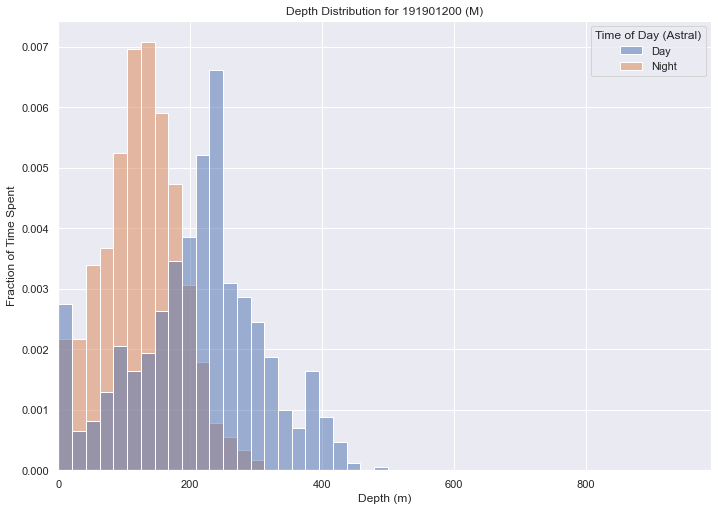

In [13]:
for i in range(len(meta["eventid"])):
    id = meta["eventid"][i]
    subset = master.loc[master['Id'] == id]
    subset_day = subset.loc[subset['Time of Day (Astral)'] == 'Day']
    subset_night = subset.loc[subset['Time of Day (Astral)'] == 'Night']
    subset_2 = pd.concat([subset_day, subset_night], ignore_index=True)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.histplot(subset_2, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
    ax.set_xlim(0, master["Depth(m)"].max())
    ax.set_ylabel('Fraction of Time Spent')
    ax.set_xlabel('Depth (m)')
    ax.set_title('Depth Distribution for ' + str(id) + ' (' + meta['sex'][i] +')')
    plt.show()

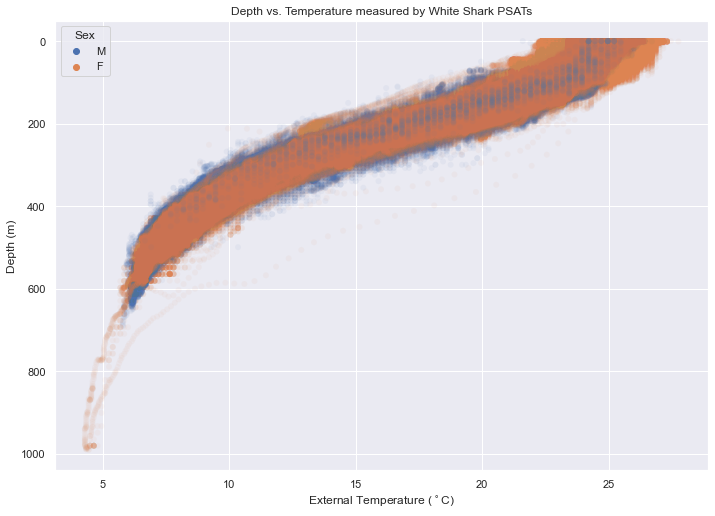

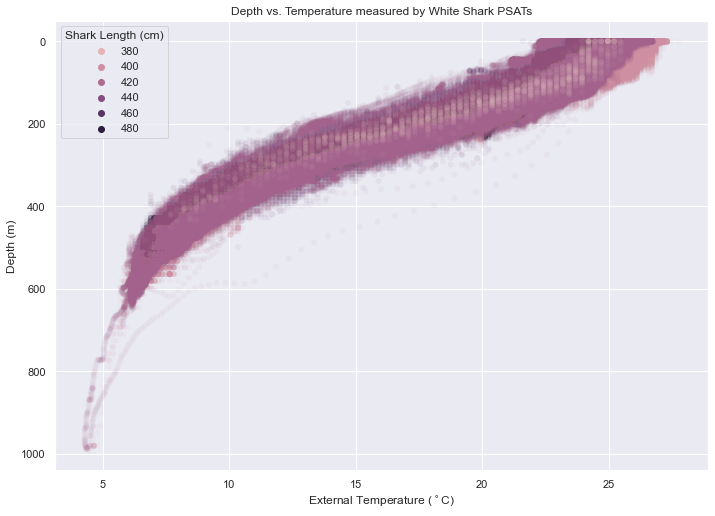

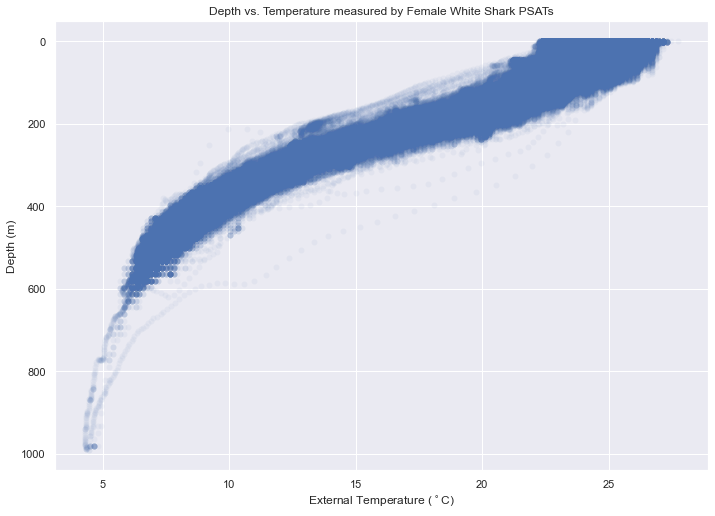

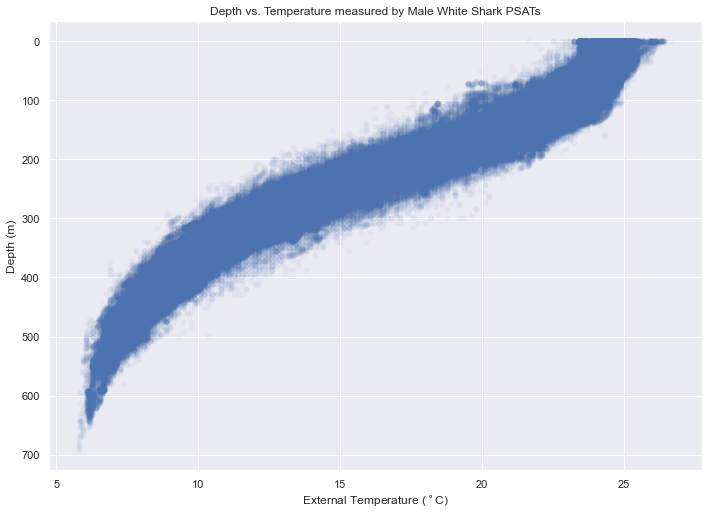

In [14]:
# external temp vs depth for sharks
sns.set_theme(color_codes=True)
ax = sns.scatterplot(data=master, x="External Temp (c)", y="Depth(m)", alpha = 0.05, linewidth=0, hue="Sex")
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('External Temperature ($^\circ$C)')
ax.set_title("Depth vs. Temperature measured by White Shark PSATs")
plt.show()

sns.set_theme(color_codes=True)
ax = sns.scatterplot(data=master, x="External Temp (c)", y="Depth(m)", alpha = 0.05, linewidth=0, hue="Shark Length (cm)")
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('External Temperature ($^\circ$C)')
ax.set_title("Depth vs. Temperature measured by White Shark PSATs")
plt.show()


fem = master[master["Sex"] == "F"]
mal = master[master["Sex"] == "M"]

# temp v depth for female's
sns.set_theme(color_codes=True)
ax = sns.scatterplot(data=fem, x="External Temp (c)", y="Depth(m)", alpha = 0.05, linewidth=0)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('External Temperature ($^\circ$C)')
ax.set_title("Depth vs. Temperature measured by Female White Shark PSATs")
plt.show()

# temp v depth for both sex's
sns.set_theme(color_codes=True)
ax = sns.scatterplot(data=mal, x="External Temp (c)", y="Depth(m)", alpha = 0.05, linewidth=0)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('External Temperature ($^\circ$C)')
ax.set_title("Depth vs. Temperature measured by Male White Shark PSATs")
plt.show()

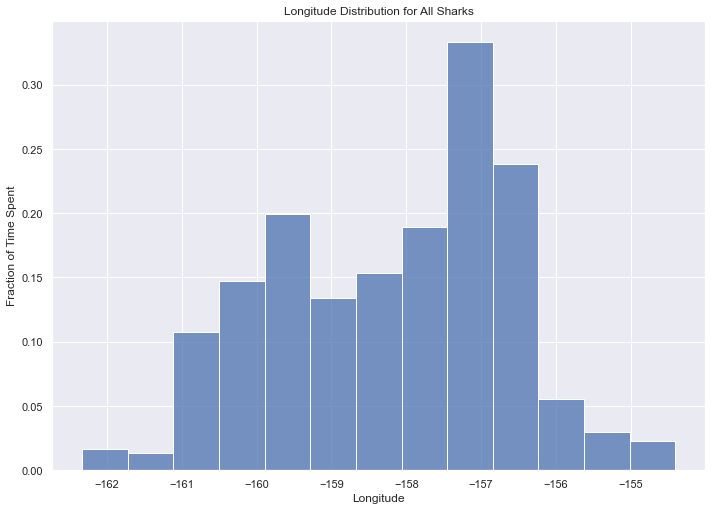

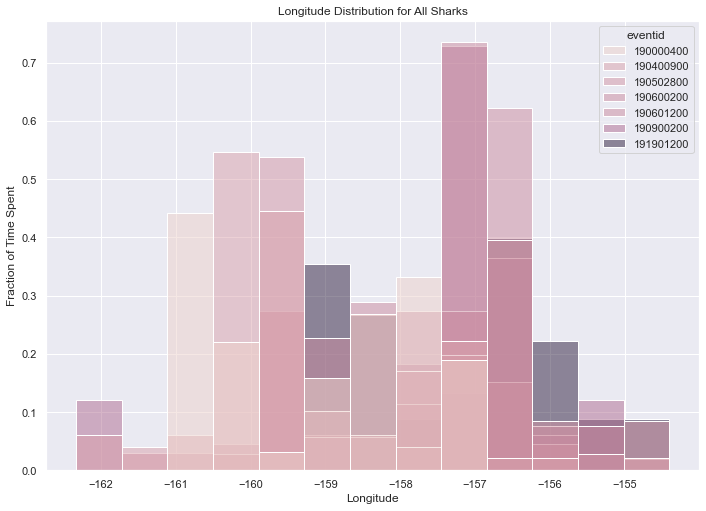

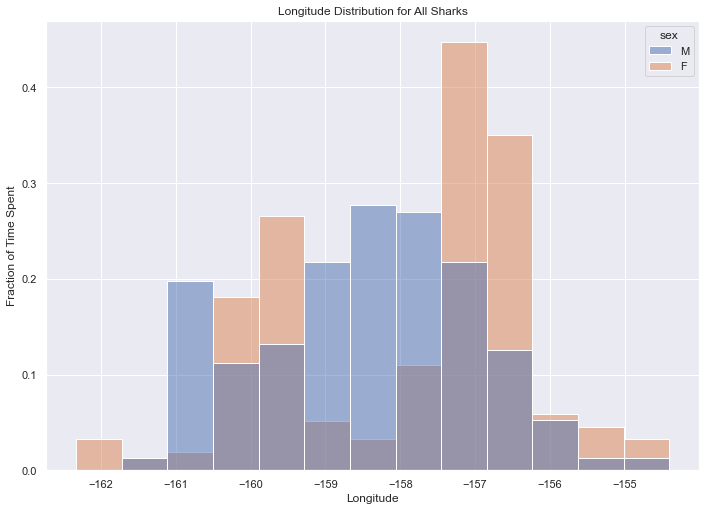

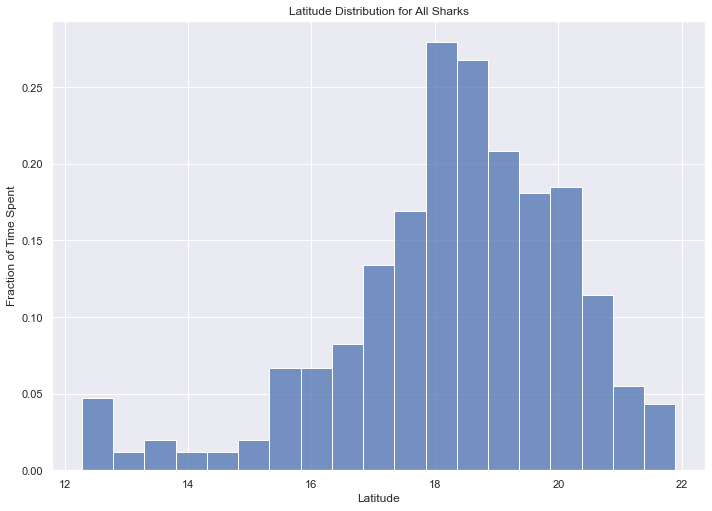

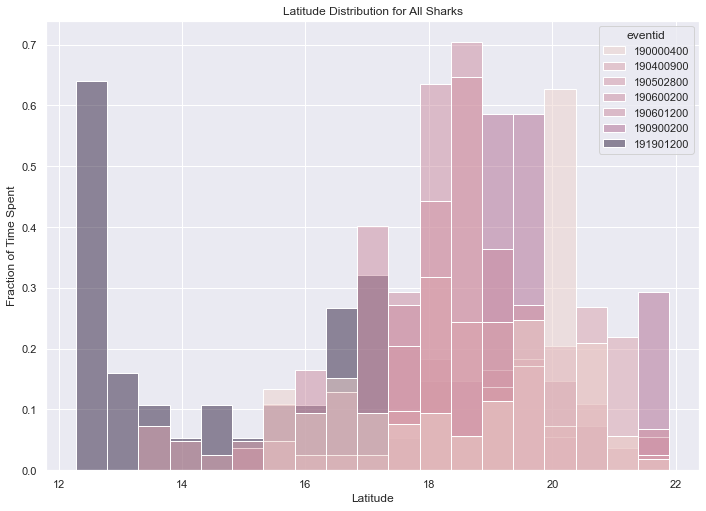

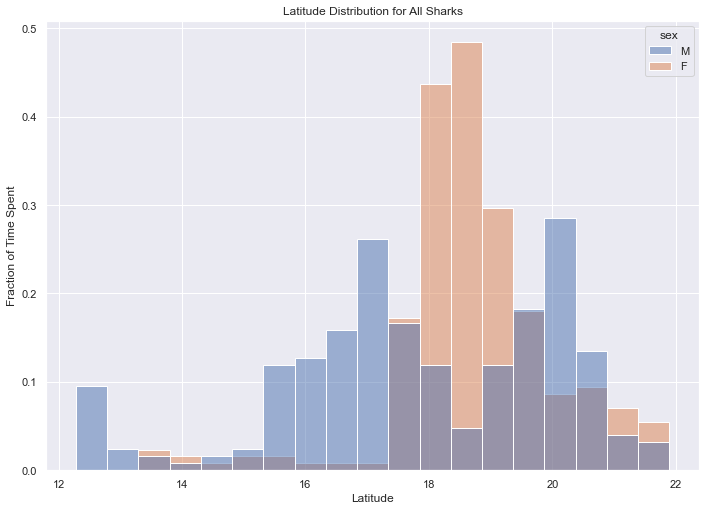

In [15]:
# Latitude and Longitude
ax = sns.histplot(ssm_archivals, x="longitude", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Longitude')
ax.set_title('Longitude Distribution for All Sharks')
plt.show()

ax = sns.histplot(ssm_archivals, x="longitude", hue="eventid", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Longitude')
ax.set_title('Longitude Distribution for All Sharks')
plt.show()

ax = sns.histplot(ssm_archivals, x="longitude", hue="sex", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Longitude')
ax.set_title('Longitude Distribution for All Sharks')
plt.show()

ax = sns.histplot(ssm_archivals, x="latitude", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Latitude')
ax.set_title('Latitude Distribution for All Sharks')
plt.show()

ax = sns.histplot(ssm_archivals, x="latitude", hue="eventid", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Latitude')
ax.set_title('Latitude Distribution for All Sharks')
plt.show()

ax = sns.histplot(ssm_archivals, x="latitude", hue="sex", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Latitude')
ax.set_title('Latitude Distribution for All Sharks')
plt.show()


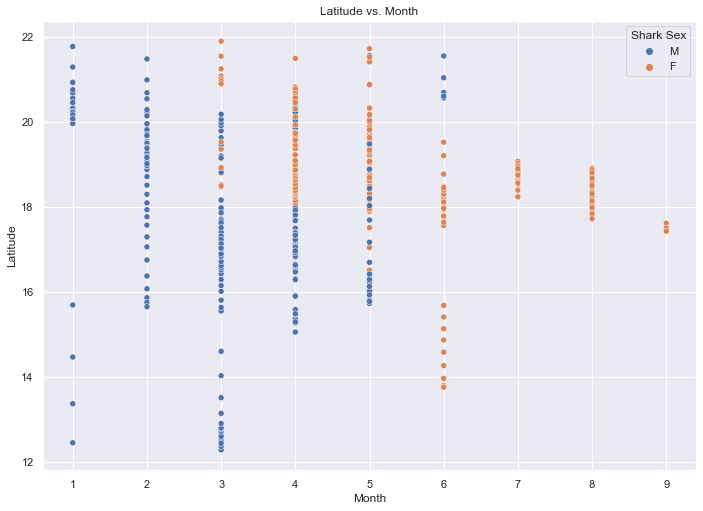

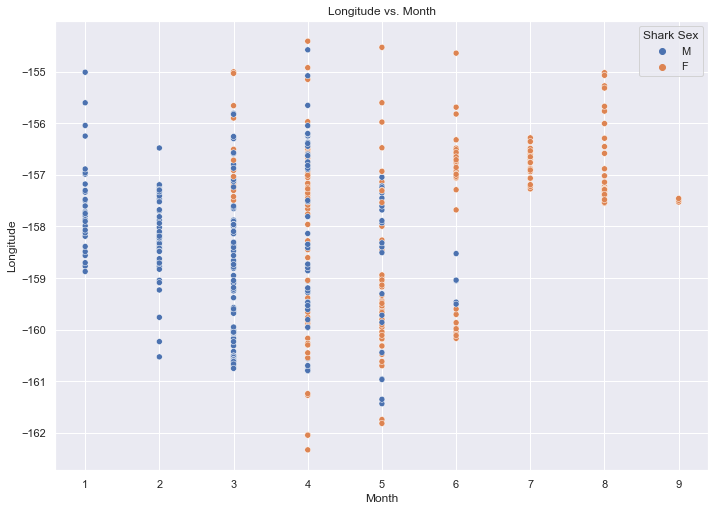

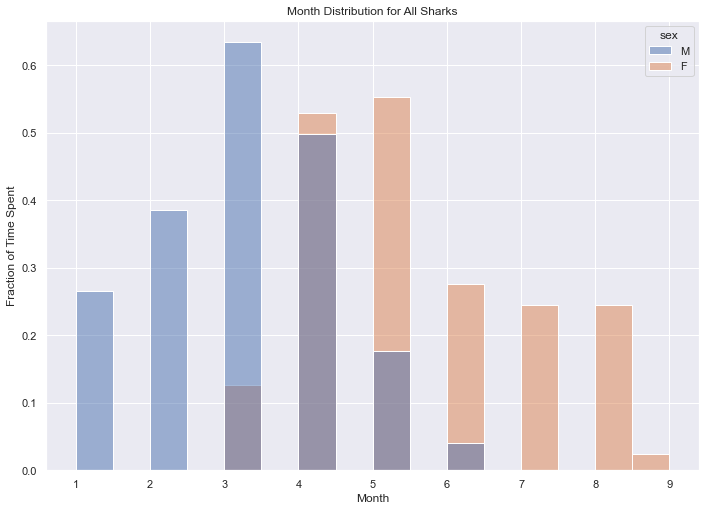

In [16]:
# month v latitude
ax = sns.scatterplot(data=ssm_archivals, x="month", y="latitude", hue="sex")
ax.set_title('Latitude vs. Month')
ax.set_ylabel('Latitude')
ax.set_xlabel('Month')
ax.legend(title='Shark Sex')
plt.show()

# month v Longitude (could show when they are entering)
ax = sns.scatterplot(data=ssm_archivals, x="month", y="longitude", hue="sex")
ax.set_title('Longitude vs. Month')
ax.set_ylabel('Longitude')
ax.set_xlabel('Month')
ax.legend(title='Shark Sex')
plt.show()

# general month dist
ax = sns.histplot(ssm_archivals, x="month", hue="sex", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Month')
ax.set_title('Month Distribution for All Sharks')
plt.show()

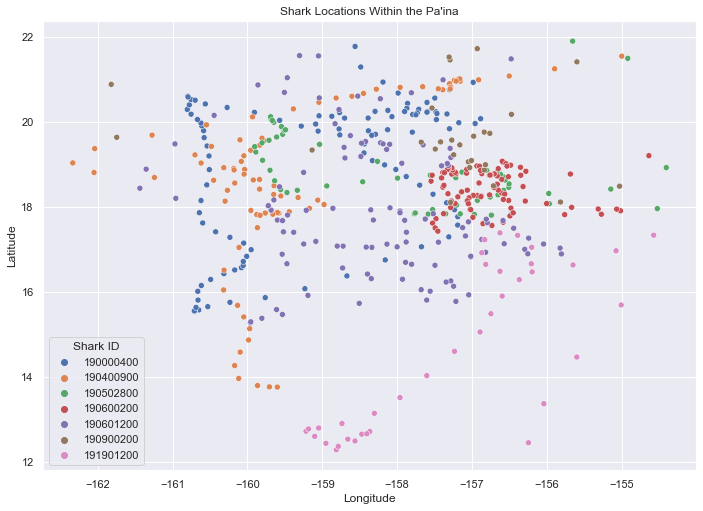

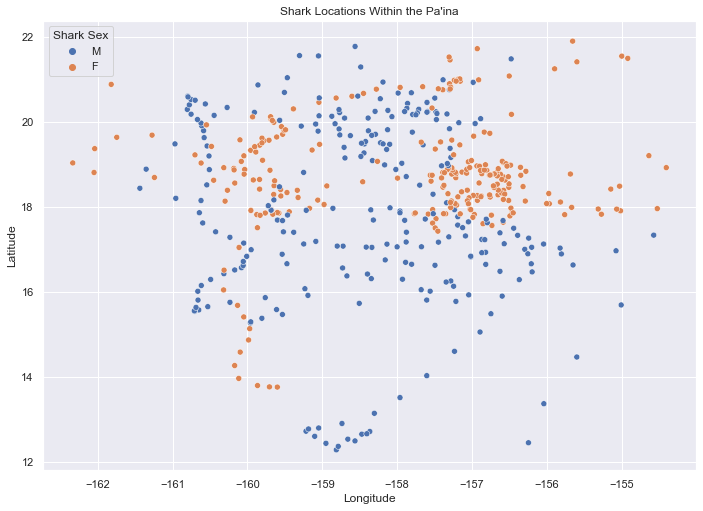

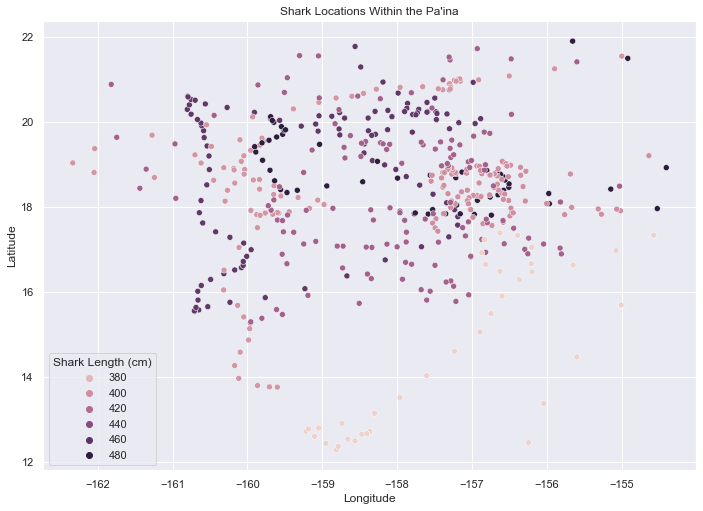

In [17]:
ssm_archivals['eventid'] = ssm_archivals.apply(lambda row: str(row['eventid']), axis=1)
ax = sns.scatterplot(data=ssm_archivals, x="longitude", y="latitude", hue="eventid")
ax.set_title('Shark Locations Within the Pa\'ina')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.legend(title='Shark ID')
plt.show()

ax = sns.scatterplot(data=ssm_archivals, x="longitude", y="latitude", hue="sex")
ax.set_title('Shark Locations Within the Pa\'ina')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.legend(title='Shark Sex')
plt.show()

ax = sns.scatterplot(data=ssm_archivals, x="longitude", y="latitude", hue="length")
ax.set_title('Shark Locations Within the Pa\'ina')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.legend(title='Shark Length (cm)')
plt.show()

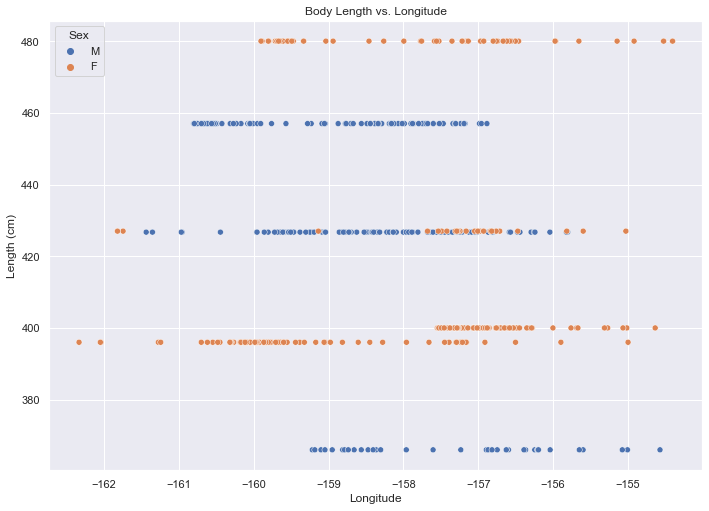

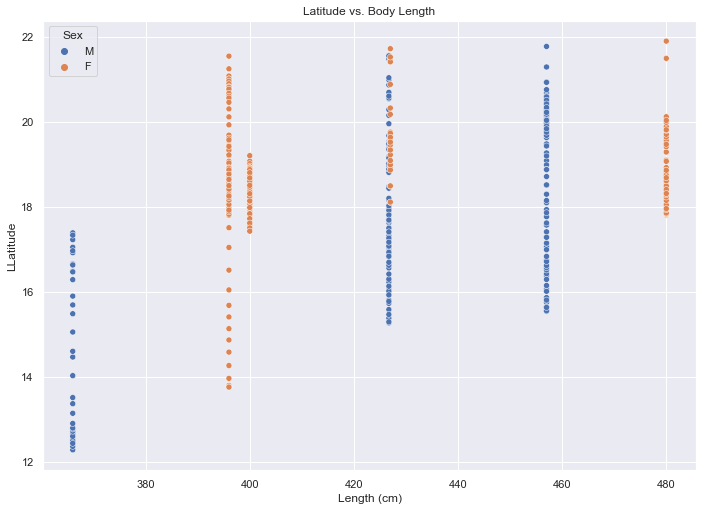

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


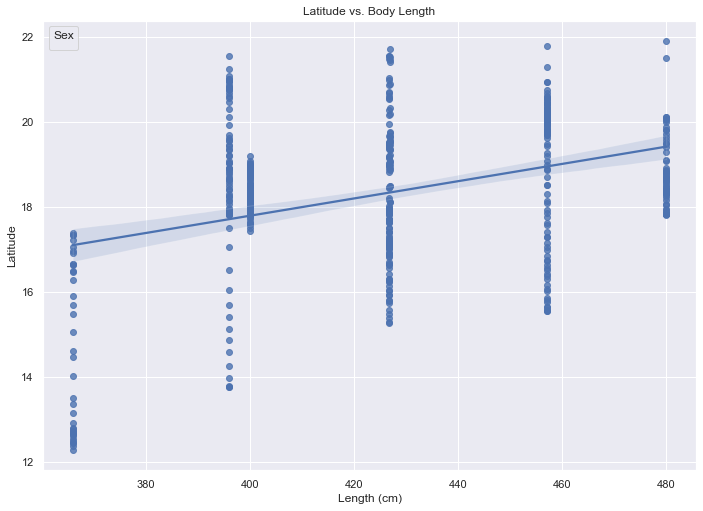

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


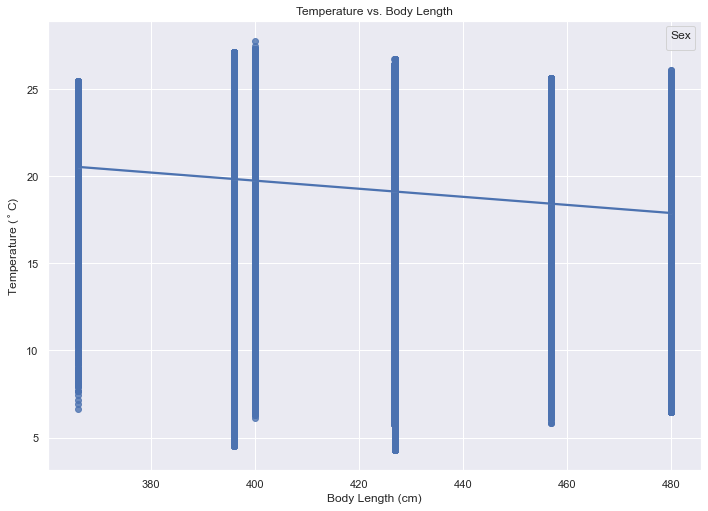

In [18]:
# shark length
ax = sns.scatterplot(data=ssm_archivals, x="longitude", y="length", hue="sex")
ax.set_title('Body Length vs. Longitude')
ax.set_ylabel('Length (cm)')
ax.set_xlabel('Longitude')
ax.legend(title='Sex')
plt.show()

ax = sns.scatterplot(data=ssm_archivals, x="length", y="latitude", hue="sex")
ax.set_title('Latitude vs. Body Length')
ax.set_ylabel('LLatitude')
ax.set_xlabel('Length (cm)')
ax.legend(title='Sex')
plt.show()

ax = sns.regplot(data=ssm_archivals, x="length", y="latitude")
ax.set_title('Latitude vs. Body Length')
ax.set_ylabel('Latitude')
ax.set_xlabel('Length (cm)')
ax.legend(title='Sex')
plt.show()

ax = sns.regplot(data=master, x="Shark Length (cm)", y="External Temp (c)")
ax.set_title('Temperature vs. Body Length')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Body Length (cm)')
plt.show()

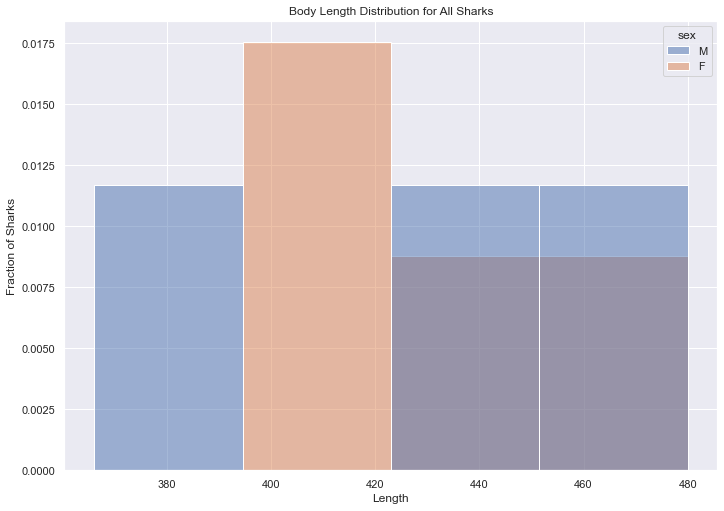

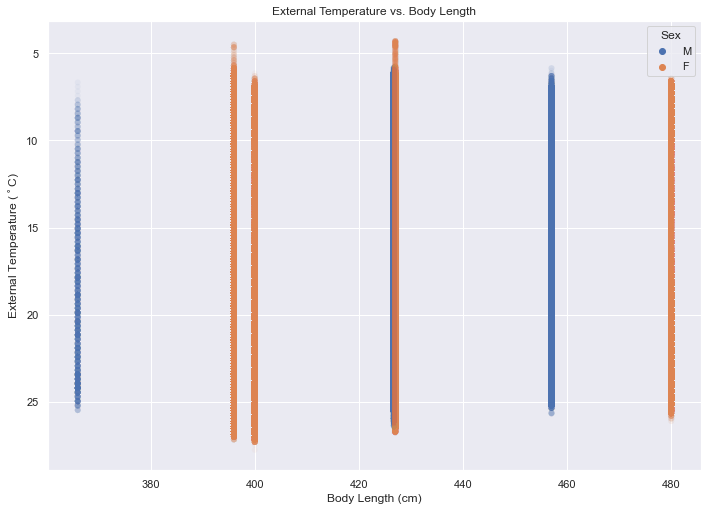

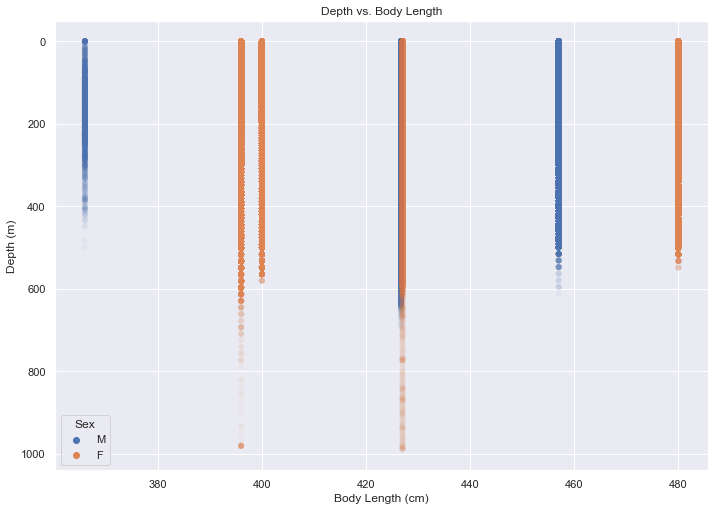

In [19]:
# BIGGER BODY LENGTH COLDER WATERS?
ax = sns.histplot(meta, x="length", hue="sex", stat="density", common_norm=False)
ax.set_ylabel('Fraction of Sharks')
ax.set_xlabel('Length')
ax.set_title('Body Length Distribution for All Sharks')
plt.show()

# temp vs body size
sns.set_theme(color_codes=True)
ax = sns.scatterplot(data=master, x="Shark Length (cm)", y="External Temp (c)", hue='Sex', alpha = 0.05, linewidth=0)
ax.set_ylabel('External Temperature ($^\circ$C)')
ax.invert_yaxis()
ax.set_xlabel('Body Length (cm)')
ax.set_title("External Temperature vs. Body Length")
plt.show()

# depth vs body size
sns.set_theme(color_codes=True)
ax = sns.scatterplot(data=master, x="Shark Length (cm)", y="Depth(m)", hue='Sex', alpha = 0.05, linewidth=0)
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_xlabel('Body Length (cm)')
ax.set_title("Depth vs. Body Length")
plt.show()

In [20]:
# Adjust for sampling rates + number of smaples per ID in general? - look at iPad notes on this >Block>Resampling White Shark Data :: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
# ssm_archivals should not need resampling
# master needs resampeling - naively resample (no sliding window average)

# https://www.w3resource.com/pandas/series/series-resample.php 

# master_resampled = master.resample('60min', on='Datetime (UTC-10)')

master["Id"].value_counts()

190900200    734400
190601200    673920
190600200    125280
190400900    116640
190502800     87840
190000400     74310
191901200      2017
Name: Id, dtype: int64

In [21]:
# may look at external temp v latitude if can string data together

KeyError: 'Latitude'